# Diffusion: from random motion to AI image generation

Many processes in nature involve random motion
 - Heat transport in solids
 - Virus particles spreading in air
 - Animals moving in ecosystems

These are commonly modelled by mathematicians as a random walk.

A single random walk seems completely unpredictable.

However, when you look at many random walkers, or at longer time and length scales, the average behaviour becomes predictable. There is a lot of mathematical theory - which you will learn as part of the MARS course - which can be used to describe this behaviour.

AI image generation models ("diffusion models") add random noise to images. They then learn how to reverse this random process, generating images from noise.


We start by importing some standard Python libraries - press shift+enter on each cell to run it:

In [134]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, interactive_output, VBox, HBox, Label


This is plotting code used later - please don't change this. Again, press shift+enter on the cell to run it: 

In [135]:
def visualize_positions(pos, trail=True, max_particles=1000):
    # --- Animation setup ---
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_aspect("equal")
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_title("Random walk (diffusion)")

    if trail:
        line, = ax.plot([], [], lw=2)
        point, = ax.plot([], [], "ro")
        
        def init():
            line.set_data([], [])
            point.set_data([], [])
            return line, point
        
        def update(frame):
            line.set_data(pos[:frame, 0], pos[:frame, 1])
            point.set_data([pos[frame, 0]], [pos[frame, 1]])
            return line, point
    else:
        scat = ax.scatter([], [], s=5, alpha=0.5)

        N = min(pos.shape[1], max_particles)
        
        def init():
            scat.set_offsets(np.empty((0, 2)))
            return scat,
        
        def update(frame):
            xy = pos[frame, :N]
            scat.set_offsets(xy)
            return scat,    
            
    anim = animation.FuncAnimation(
                fig,
                update,
                frames=len(pos),
                init_func=init,
                interval=50,
                blit=True
            )
    
    plt.close(fig)
    
    # --- Display animation ---
    return HTML(anim.to_jshtml())

## Part 1 - A single random particle

What are we modelling?
A particle that:
- takes small, random steps, and
- has no memory, i.e. the direction and length of the next step is not affected by earlier steps.

This is called a **random walk**. We can implement it as follows:

In [136]:
# --- Simulation ---
def simulate_one_particle(n_steps=300, step_size=0.1, seed=0):
    rng = np.random.default_rng(seed)
    pos = np.zeros((n_steps + 1, 2))
    for t in range(n_steps):
        step = step_size * rng.standard_normal(2)
        # OTHER OPTIONS TO CHOOSE (UNCOMMENT)
        #step = step_size * rng.choice([-1, 1], size=2)
        #step = step_size * np.array([rng.standard_normal(), 0])
        pos[t + 1] = pos[t] + step
    return pos

Here we have defined a function `simulate_one_particle` that first

- initalizes the random number generator
   ```rng = np.random.default_rng(seed)```

- makes an empty array of shape (n_steps + 1) x 2 to store the path of the particle
   ```pos = np.zeros((n_steps + 1, 2))```

and then loops over all of the timesteps. For each timestep, it

- generates a pair of normally distributed random numbers
    ```rng.standard_normal(2)```
- scales this by a number (the step-size)
    ```step = step_size * rng.standard_normal(2)```
- adds this to the current position `pos[t]` and stores it in `pos[t+1]`
    ```pos[t + 1] = pos[t] + step```
  Note that here `pos[t]` is the whole `t`-th row of the `pos` matrix.

Finally, it returns the position array (so that you can plot / visualize it).

The loop is illustrated in the video below


In [1]:
from IPython.display import Video
Video("ParticleUpdateStepGhost.mp4", width=600)

Now run the simulation:

In [138]:
pos = simulate_one_particle(n_steps=50, step_size=0.2, seed=0)

After the function has returned, `pos` is a `(n_steps+1) x 2` array, containing the positions of the particle at each timestep. It can be visualised interactively:

In [139]:
visualize_positions(pos)

### Tasks:
- change value of `step_size` in `pos = random_walk(n_steps=50, step_size=0.2, seed=0)` above and rerun the code for interactive visualisation. What is different?
- try other random motions in the definition of `random_walk` (see commented out code)

## Part 2 - Many particles

What changes when we simulate many particles? Each individual particle is random - but the average behaviour of the whole population of particles is predictable.

We can simulate many random walks at the same time with the following code:

In [140]:
def simulate_many_particles(n_particles=500, n_steps=300, step_size=0.1, seed=0):
    rng = np.random.default_rng(seed)
    pos = np.zeros((n_steps + 1, n_particles, 2))

    for t in range(n_steps):
        steps = step_size * rng.standard_normal((n_particles, 2))
        pos[t + 1] = pos[t] + steps

    return pos

This works in a very similar way to `simulate_one_particle`, except that we make a three-dimensional results array. Now, at each timestep, we generate the random moves for all particles at the same time using `rng.standard_normal((n_particles, 2))`. Doing it like this in Python allows the `numpy` library to generate these numbers, and perform the scaling and addition, in parallel.

Now run the simulations with:

In [161]:
pos = simulate_many_particles(n_particles=500, n_steps=50, step_size=0.2, seed=0)

It can be visualised as follows:

In [162]:
visualize_positions(pos, trail=False)

With many particles, many properties of the overall population can be predicted. For instance, as time $t$ grows, mathematical results establish that the average distance from the starting point is proportional to the square-root of time, $\sqrt{t}$. Lets verify this:

The distance from the origin of the particles is given by $\sqrt{x^2 + y^2}$. We can calculate these for all particles at the same time using

In [167]:
r = np.sqrt(pos[:,:,0]**2 + pos[:,:,1]**2)

Now r is a `n_steps x n_particles` array. We can calculate the mean over all particles at each timestep using

In [169]:
mean_r = np.sum(r, axis=1)/r.shape[1]


We now want to fit a function of the form t = a mean_r^2. We can find the best value for a using the following code

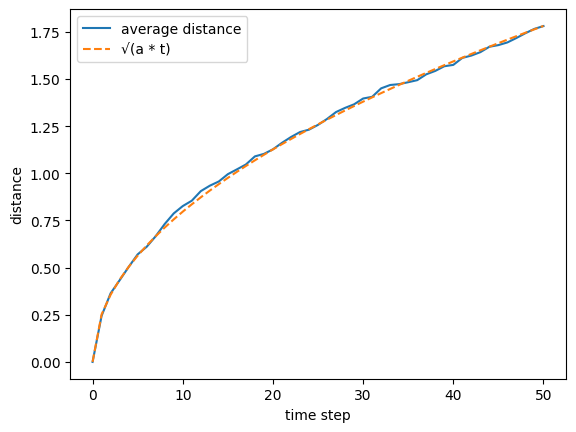

In [165]:


mean_r = np.sum(r, axis=1)/r.shape[1]

t = np.arange(len(mean_r))

# Find best fit (least squares error) for t ~ a mean_r**2
a = (t[1:] @ mean_r[1:]**2) / (t[1:] @ t[1:])


plt.figure()
plt.plot(t, mean_r, label="average distance")
plt.plot(t, np.sqrt(t)*np.sqrt(a), "--", label="√(a * t)")
plt.xlabel("time step")
plt.ylabel("distance")
plt.legend()
plt.show()

## Part 3 — From particles to pixels

- An image is just an array of numbers (pixels).
- We can treat each pixel like a 1D particle.
- Adding noise to an image == many particles undergoing random walks.

Let us now load a grayscale example image from scikit-image, which is a popular Python library for manipulating images

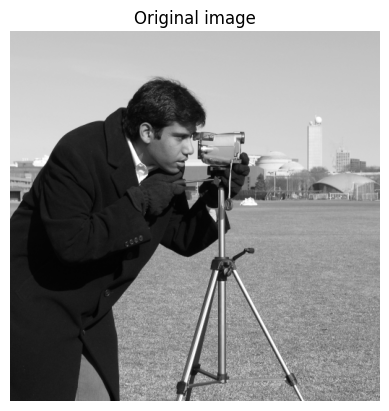

In [144]:
from skimage import data, img_as_float
from skimage.transform import rescale

img = img_as_float(data.camera())
plt.imshow(img, cmap="gray")
plt.title("Original image")
plt.axis("off")
plt.show()

Here `img` is actually just an array of numbers betwen 0 and 1. We can look at its shape:

In [145]:
img.shape

(512, 512)

and print the numbers in the top-left corner:

In [146]:
img[:4,:4]

array([[0.78431373, 0.78431373, 0.78431373, 0.78431373],
       [0.78431373, 0.78039216, 0.78039216, 0.78431373],
       [0.78039216, 0.78039216, 0.78039216, 0.78431373],
       [0.78431373, 0.78431373, 0.78039216, 0.78039216]])

We can plot a histogram of the pixel values:

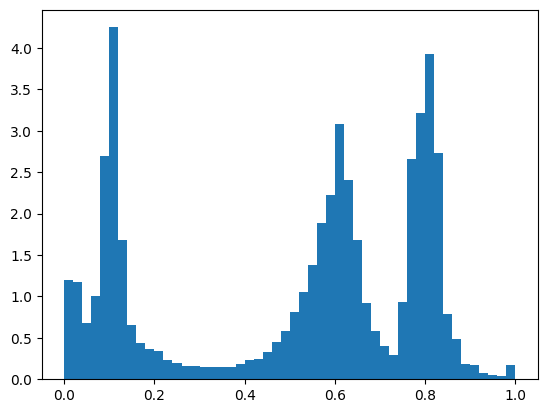

In [147]:
plt.hist(img.flatten(), bins=50, density=True)
plt.show()

Here `img.flatten()` takes the two-dimensional array `img`, and turns it into a 1-D array.

Which parts of the image correspond to the peaks in the intensity histogram?

We can now do the same random walk as before, but instead in 1-D. Now the x-positions of the particle correspond to the pixel intensities, and they start at their values in the image.

To make it a bit quicker we'll shrink the image

In [148]:
img_shrunk = rescale(img, 0.25)

In [149]:
def diffuse_1d(start_positions, n_steps=200, step_size=0.1, seed=0):
    rng = np.random.default_rng(seed)
    n_particles = start_positions.shape[0]
    x = np.zeros((n_steps + 1, n_particles))
    x[0,:] = start_positions
    for t in range(n_steps):
        x[t+1] = x[t] + step_size * rng.standard_normal(n_particles)
    return x

In [150]:
pos = diffuse_1d(img_shrunk.flatten(), n_steps=200, step_size=0.1, seed=0)

In [151]:
def visualize_1d(x, max_points=10000):
    fig, ax = plt.subplots(figsize=(6, 3))
    
    ax.set_xlim(-4, 4)
    ax.set_ylim(-0.1, 0.1)
    ax.set_yticks([])
    ax.set_xlabel("position")
    ax.set_title("1D diffusion (same random walk, but only moving along one axis)")
    
    scat = ax.scatter([], [], s=5, alpha=0.5)

    n = min(max_points, x.shape[1])
    def init():
        scat.set_offsets(np.empty((0, 2)))
        return scat,
    
    def update(frame):
        y = np.zeros_like(x[frame, :n])  # all points on a line
        offsets = np.column_stack((x[frame, :n], y))
        scat.set_offsets(offsets)
        return scat,
    
    anim = animation.FuncAnimation(
        fig,
        update,
        frames=x.shape[0],
        init_func=init,
        interval=40,
        blit=True
    )
    
    plt.close(fig)
    return HTML(anim.to_jshtml())

In [152]:
visualize_1d(pos)

It's much easier to see what's going on from the histograms

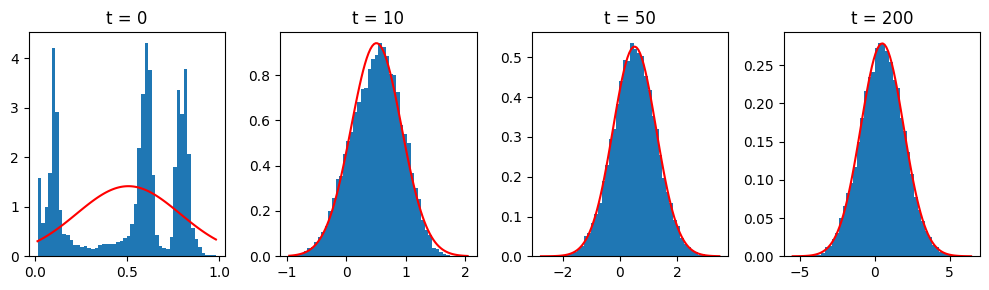

In [153]:
times = [0, 10, 50, 200]

plt.figure(figsize=(10,3))
for i, t in enumerate(times):
    plt.subplot(1, len(times), i+1)
    plt.hist(pos[t], bins=50, density=True)
    x = np.linspace(min(pos[t]), max(pos[t]), 100)
    mu = np.mean(pos[t])
    sigma2 = np.var(pos[t])
    f = 1/np.sqrt(2*np.pi*sigma2)*np.exp(-0.5*(x-mu)**2/sigma2)
    plt.plot(x, f, 'r-')
    plt.title(f"t = {t}")
plt.tight_layout()
plt.show()

We see that we start with a complicated distribution of pixel values, but over time this becomes closer and closer to a "normal" distribution (shown by the red line).

We can turn these back into images (scaling the values back into the range 0-1 so we can view them)

In [154]:
def pos_to_image(pos):
    min_val = np.percentile(pos, 5)
    max_val = np.percentile(pos, 95)
    new_image = (pos - min_val)/(max_val - min_val)
    new_image = np.clip(new_image, 0, 1)
    return new_image.reshape(img_shrunk.shape)

and obtain noisy images:

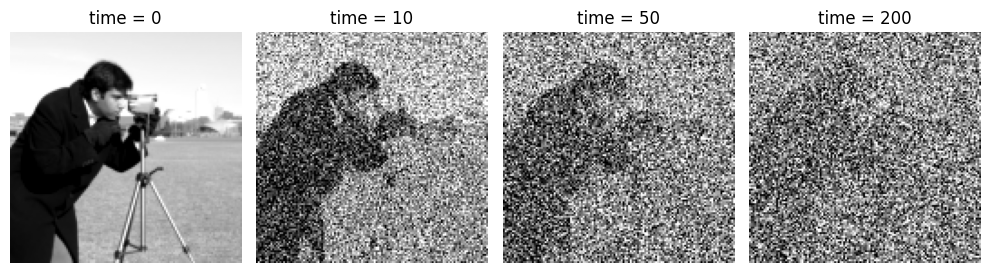

In [155]:
times = [0, 10, 50, 200]

plt.figure(figsize=(10,3))
for i, t in enumerate(times):
    plt.subplot(1, len(times), i+1)

    plt.imshow(pos_to_image(pos[t]), cmap="gray")
    plt.title(f"time = {t}")
    plt.axis("off")
plt.tight_layout()
plt.show()

You can see that as time goes by the image becomes noisier and noiser. Which parts of the image can you still make out at time=50?

## Part 4 - AI image generation

We've shown that by adding noise we can take an image and turn it into a much simpler distribution.

AI image generation learns to reverse this process - to take a noisy image and guess the most likely clean image

Here we've trained up a simple diffusion model on a dataset of butterflies for you to explore. As these de-noising steps take time (and a GPU) we've pre-computed some results for you.

This example takes an image from the dataset and adds noise to it. The neural network is given this noisy image and tries to predict the original image.

You can change the image and the amount of noise using the sliders.

In [156]:
noise_denoise = np.load("noise_denoise_samples.npz")

In [157]:
noise_denoise['init_image'].shape

(4, 3, 128, 128)

In [158]:
noise_denoise['noised_images'].shape

(20, 4, 3, 128, 128)

In [159]:
def rescale_img(img):
    return np.clip(0.5*(img+1.0).transpose((1,2,0)), 0, 1)

def show_noise(steps=0, image=0):
    """
    Interactive visualisation for a single particle random walk.
    Splits view into (1) path and (2) distance from start vs time.
    """

    fig, ax = plt.subplots(1, 3)

    # Path
    ax[0].imshow(rescale_img(noise_denoise["init_image"][image]))
    ax[0].set_title("Initial image")

    ax[1].imshow(rescale_img(noise_denoise["noised_images"][steps, image]))
    ax[1].set_title("Nosied image")
    
    ax[2].imshow(rescale_img(noise_denoise["pred_x0"][steps, image]))
    ax[2].set_title("Predicted image")

    plt.show()


steps=IntSlider(value=0, min=0, max=noise_denoise['noised_images'].shape[0]-1)
image=IntSlider(value=0, min=0, max=noise_denoise['noised_images'].shape[1]-1)

out = interactive_output(show_noise, {"steps": steps, "image":image})

VBox([HBox([Label("steps:"), steps]), HBox([Label("image: "), image]), out])

What do you notice about the predicted images? How do the predictions at higher levels of noise (more steps) differ from those at lower levels of noise?

### Denoising an image in multiple steps

As we saw above, generating an image from noise in one step doesn't work very well. Instead, image generating AIs usually use many steps and gradually remove part of the noise at each step.

In [2]:
from IPython.display import Video
Video("DenoiseVideo.mp4", width=600)

Here we only show the intermediate results at some of the steps (as it uses 50 steps to sample from the model).